<a href="https://colab.research.google.com/github/SofiNurul/SKRIPSI/blob/main/Percobaan_Sentiment_Analisis_Produk_Penghilang_Bekas_Luka_di_Shopee_Dengan_Algoritma_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT LIBRARY DAN DATASET**

---




In [1]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from wordcloud import WordCloud
import joblib

Mengunduh resource nltk yang diperlukan

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Muat dataset

In [3]:
df = pd.read_csv('dataulasan_manual.csv', encoding='MacRoman')
df.head(10)

,no,username,date,content,texture,effectiveness,absorption capacity,score,sentiment
0,1,z*****e,10/10/2024,Pertama kali coba karena baca ulasan di Quora ...,cream gel,baru pertama x coba Guys mudah2an manjur,pas,4,positif
1,2,dindardew,03/09/2024,Penasaran bgt dari dulu udah laser jg bekas lu...,lembut dan dingin ke kulit,belum tau baru d pakai sehari,cepet,5,netral
2,3,dikamungil,03/09/2024,"Udah ku pke beberapa kali sih, semoga bermanfa...",gel,baik,cepat,5,positif
3,4,cakranouval,11/08/2024,"kecewa, kemasan penyok",gel lembut,efektif,cepat,3,negatif
4,5,ilhamansyari22,18/06/2024,Barang sesuai pesanan ‚ò∫Ô∏è,gel lembut,efektif,cepat,5,netral
5,6,inggihsatrianisatriani,18/06/2024,Baru pertama kali coba mudah mudahan bisa puda...,baik,blom tau baru coba,bagus,5,positif
6,7,m*****4,06/06/2024,"Baru mau nyoba, semoga manjur menghilangkan be...",gel,bagus,bagus,5,positif
7,8,nonaa2,02/06/2024,"Cottonbud gak dikasih, pelit banget, gimana pa...",gel,bagus,baik,3,negatif
8,9,linarifqun,12/05/2024,Alhamdulillah Paketku sudah sampai pesanannya ...,gel,bagus,bagus,3,positif
9,10,v*****8,11/05/2024,"Dikasih thr sama kakaknya, MasyaAllah berkah s...",gel kental,semoga bekerja dengan baik,belum tau,5,positif


# **DATA SELECTION**

---



Melakukan data selection

In [4]:
# Memilih kolom yang relevan
df_selected = df[['username', 'content', 'sentiment']]
# Menghapus baris yang memiliki nilai kosong pada kolom 'content'
df_selected.dropna(subset=['content'], inplace=True)
# Menampilkan 10 baris pertama dari data yang telah diseleksi
df_selected.head(10)

<ipython-input-4-140f985cd337>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.dropna(subset=['content'], inplace=True)


,username,content,sentiment
0,z*****e,Pertama kali coba karena baca ulasan di Quora ...,positif
1,dindardew,Penasaran bgt dari dulu udah laser jg bekas lu...,netral
2,dikamungil,"Udah ku pke beberapa kali sih, semoga bermanfa...",positif
3,cakranouval,"kecewa, kemasan penyok",negatif
4,ilhamansyari22,Barang sesuai pesanan ‚ò∫Ô∏è,netral
5,inggihsatrianisatriani,Baru pertama kali coba mudah mudahan bisa puda...,positif
6,m*****4,"Baru mau nyoba, semoga manjur menghilangkan be...",positif
7,nonaa2,"Cottonbud gak dikasih, pelit banget, gimana pa...",negatif
8,linarifqun,Alhamdulillah Paketku sudah sampai pesanannya ...,positif
9,v*****8,"Dikasih thr sama kakaknya, MasyaAllah berkah s...",positif


# **DATA PREPROCESSING**

---



Daftar stopwords dari NLTK dan tambahan khusus Bahasa Indonesia

In [5]:
stopwords_tambahan = list([
    'gk', 'yg', 'nya', 'dan', 'dll', 'saja', 'juga', 'untuk', 'dengan', 'atau',
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin'
])

Inisialisasi Stemmer dari Sastrawi

In [6]:
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

Pembersihan teks

In [7]:
def clean_text(teks):
    if not isinstance(teks, str):
        return ""
    teks = teks.lower()
    teks = re.sub(r'http\S+|www\S+|https\S+', '', teks)  # Menghapus URL
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)  # Menghilangkan karakter non-ASCII
    teks = teks.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    teks = re.sub(r'\d+', '', teks)  # Menghapus angka
    return teks

Fungsi untuk tokenisasi

In [8]:
def tokenize(teks):
    return teks.split()

Fungsi untuk stemming

In [9]:
def apply_stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

Terapkan pra-pemrosesan ke data

In [10]:
df_selected['cleaned_content'] = df_selected['content'].apply(clean_text)

<ipython-input-10-e0c27e1bd33e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['cleaned_content'] = df_selected['content'].apply(clean_text)


Menampilkan hasil tokenisasi dan stemming untuk 5 sampel teratas

In [11]:
print("\n=== Hasil Tokenisasi dan Stemming untuk 5 Sampel Teratas ===")
for i in range(5):  # Menampilkan 5 contoh pertama
    original_text = df_selected.iloc[i]['content']
    cleaned_text = df_selected.iloc[i]['cleaned_content']
    tokens = tokenize(cleaned_text)
    stemmed_tokens = apply_stemming(tokens)

    print(f"Contoh {i+1}:")
    print("Teks Asli:", original_text)
    print("Setelah Pembersihan:", cleaned_text)
    print("Setelah Tokenisasi:", tokens)
    print("Setelah Stemming:", stemmed_tokens)
    print("-" * 50)


=== Hasil Tokenisasi dan Stemming untuk 5 Sampel Teratas ===
Contoh 1:
Teks Asli: Pertama kali coba karena baca ulasan di Quora katanya bagus, semoga ngefek bekas2 korengan pas hamil anak ke 2 memudar, hasilnya pemakaian 1 botol insyaallah akan aku update ya.. kalo emang bagus pasti repurchase (beli lagi) di toko ini, Sellernya ramah dan amanah.. suka kalo di chat gercep di balas gak pake lama, pengiriman ke Jakarta juga cepat.i
Setelah Pembersihan: pertama kali coba karena baca ulasan di quora katanya bagus semoga ngefek bekas korengan pas hamil anak ke  memudar hasilnya pemakaian  botol insyaallah akan aku update ya kalo emang bagus pasti repurchase beli lagi di toko ini sellernya ramah dan amanah suka kalo di chat gercep di balas gak pake lama pengiriman ke jakarta juga cepati
Setelah Tokenisasi: ['pertama', 'kali', 'coba', 'karena', 'baca', 'ulasan', 'di', 'quora', 'katanya', 'bagus', 'semoga', 'ngefek', 'bekas', 'korengan', 'pas', 'hamil', 'anak', 'ke', 'memudar', 'hasilnya', 'pe

# **DATA TRANSFORMASI**

---



Vektorisasi menggunakan TF-IDF dengan unigram, bigram, dan trigram

In [12]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_df=0.75,
    min_df=3,
    stop_words=stopwords_tambahan,
    max_features=5000
)

Mengubah teks pada kolom 'cleaned_content' menjadi fitur numerik menggunakan TF-IDF

In [13]:
X_tfidf = vectorizer.fit_transform(df_selected['cleaned_content'])

Mengambil fitur nama TF-IDF

In [14]:
feature_names = vectorizer.get_feature_names_out()

Mengubah hasil TF-IDF menjadi DataFrame untuk kemudahan visualisasi

In [15]:
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names[:X_tfidf.shape[1]])

Menambahkan kolom 'username' dan 'cleaned_content' untuk referensi

In [16]:
tfidf_df.insert(0, 'username', df_selected['username'].reset_index(drop=True))
tfidf_df.insert(1, 'cleaned_content', df_selected['cleaned_content'].reset_index(drop=True))

# Menampilkan 5 ulasan teratas setelah TF-IDF
print("\n=== 5 Ulasan Teratas Setelah TF-IDF ===")
print(tfidf_df.head(5))


=== 5 Ulasan Teratas Setelah TF-IDF ===
         username                                    cleaned_content  aamiin  \
0         z*****e  pertama kali coba karena baca ulasan di quora ...     0.0   
1       dindardew  penasaran bgt dari dulu udah laser jg bekas lu...     0.0   
2      dikamungil  udah ku pke beberapa kali sih semoga bermanfaa...     0.0   
3     cakranouval                              kecewa kemasan penyok     0.0   
4  ilhamansyari22                            barang sesuai pesanan       0.0   

   abis  adain  adain promo  adalah  adha  admin  adminnya  ...  worth  \
0   0.0    0.0          0.0     0.0   0.0    0.0       0.0  ...    0.0   
1   0.0    0.0          0.0     0.0   0.0    0.0       0.0  ...    0.0   
2   0.0    0.0          0.0     0.0   0.0    0.0       0.0  ...    0.0   
3   0.0    0.0          0.0     0.0   0.0    0.0       0.0  ...    0.0   
4   0.0    0.0          0.0     0.0   0.0    0.0       0.0  ...    0.0   

   worth it  wrap  yaa  yaaa     

# **DATA MINING (Model : Naive Bayes)**

---



Membagi dataset menjadi fitur (X) dan target (y)

In [17]:
X = df_selected['cleaned_content']
y = df_selected['sentiment']

Membagi data latih dan data uji

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=42)

Latih model Naive Bayes

In [19]:
nb_model = MultinomialNB()
param_grid = {'alpha': [0.1, 0.5, 1, 5, 10]}
grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1, 5, 10]}, scoring='accuracy')

Menampilkan parameter terbaik

In [20]:
print("Parameter terbaik:", grid_search.best_params_)
best_nb_model = grid_search.best_estimator_
y_pred = best_nb_model.predict(X_test)

Parameter terbaik: {'alpha': 0.1}


Menampilkan laporan klasifikasi

In [21]:
print("\n=== Evaluasi Model ===")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


=== Evaluasi Model ===
              precision    recall  f1-score   support

     negatif       0.93      0.62      0.74        21
      netral       0.81      0.63      0.71        41
     positif       0.69      0.89      0.78        56

    accuracy                           0.75       118
   macro avg       0.81      0.72      0.75       118
weighted avg       0.78      0.75      0.75       118

Accuracy: 0.75


Confusion Matrix untuk data validasi

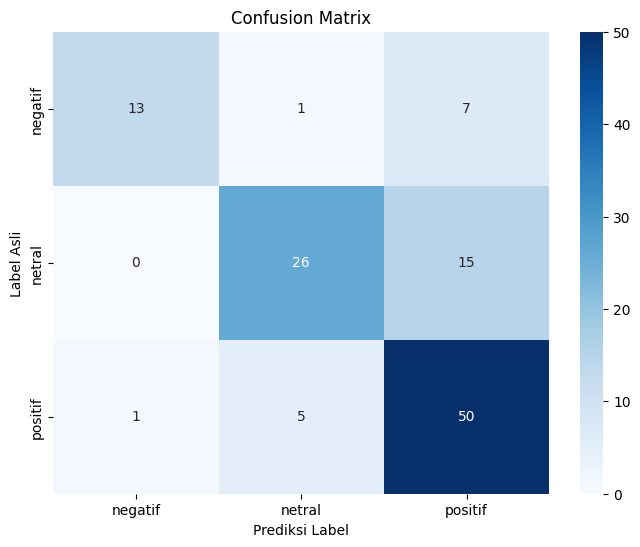


=== Beberapa contoh perbandingan Label Asli dan Label Prediksi ===
     Label Asli Label Prediksi
410     positif        positif
430     negatif        negatif
675     positif        positif
208      netral         netral
811     negatif        positif
665     negatif         netral
1066    positif        positif
832      netral        positif
58       netral         netral
1107    positif        positif


In [22]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=['negatif', 'netral', 'positif'])

# Menampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negatif', 'netral', 'positif'],
            yticklabels=['negatif', 'netral', 'positif'])
plt.xlabel("Prediksi Label")
plt.ylabel("Label Asli")
plt.title("Confusion Matrix")
plt.show()

# Membuat DataFrame perbandingan antara label asli dan label prediksi
comparison_df = pd.DataFrame({'Label Asli': y_test, 'Label Prediksi': y_pred})
print("\n=== Beberapa contoh perbandingan Label Asli dan Label Prediksi ===")
print(comparison_df.head(10))

Menghitung confusion matrix

In [23]:
classes = ['negatif', 'netral', 'positif']

# Membuat confusion matrix dengan label yang telah didefinisikan
conf_matrix_all = confusion_matrix(y_test, y_pred, labels=classes)

# Menghitung True Positives, False Positives, False Negatives, dan True Negatives untuk setiap kelas
TP = np.diag(conf_matrix_all)  # True Positives untuk setiap kelas
FP = np.sum(conf_matrix_all, axis=0) - TP  # False Positives untuk setiap kelas
FN = np.sum(conf_matrix_all, axis=1) - TP  # False Negatives untuk setiap kelas
TN = np.sum(conf_matrix_all) - (FP + FN + TP)  # True Negatives untuk setiap kelas

# Perhitungan khusus untuk kelas 'netral'
netral_index = classes.index("netral")
TNt = TP[netral_index]  # True Neutral untuk kelas netral
FNt = FN[netral_index]  # False Neutral untuk kelas netral

Menghitung Akurasi

In [24]:
total_correct = np.sum(TP)  # Semua prediksi benar (ΣTP)
total_data = np.sum(conf_matrix_all)  # Total seluruh data
accuracy = total_correct / total_data * 100

print("Akurasi = (ΣTP) / Total x 100")
print(f"= ({np.sum(TP)}) / {total_data} x 100")
print(f"= {accuracy:.2f}%\n")

Akurasi = (ΣTP) / Total x 100
= (89) / 118 x 100
= 75.42%



Menghitung Precision, Recall, dan F1-Score untuk Setiap Kelas

In [25]:
precision = TP / (TP + FP) * 100  # Dalam persen
recall = TP / (TP + FN) * 100     # Dalam persen
f1_score = 2 * (precision * recall) / (precision + recall)

# Menampilkan hasil perhitungan untuk setiap kelas
results = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
})

print("\n=== Perhitungan Presisi, Recall, dan F1-Score untuk setiap Kelas ===")
for idx, row in results.iterrows():
    print(f"\nKelas {row['Class']}:")
    print(f"Presisi = TP / (TP + FP)")
    print(f"= {TP[idx]} / ({TP[idx]} + {FP[idx]}) x 100")
    print(f"= {row['Precision']:.2f}%")

    print(f"Recall = TP / (TP + FN)")
    print(f"= {TP[idx]} / ({TP[idx]} + {FN[idx]}) x 100")
    print(f"= {row['Recall']:.2f}%")

    print(f"F1-Score = 2 * (Precision * Recall) / (Precision + Recall)")
    print(f"= 2 * ({row['Precision']:.2f}% * {row['Recall']:.2f}%) / ({row['Precision']:.2f}% + {row['Recall']:.2f}%)")
    print(f"= {row['F1-Score']:.2f}%")



=== Perhitungan Presisi, Recall, dan F1-Score untuk setiap Kelas ===

Kelas negatif:
Presisi = TP / (TP + FP)
= 13 / (13 + 1) x 100
= 92.86%
Recall = TP / (TP + FN)
= 13 / (13 + 8) x 100
= 61.90%
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
= 2 * (92.86% * 61.90%) / (92.86% + 61.90%)
= 74.29%

Kelas netral:
Presisi = TP / (TP + FP)
= 26 / (26 + 6) x 100
= 81.25%
Recall = TP / (TP + FN)
= 26 / (26 + 15) x 100
= 63.41%
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
= 2 * (81.25% * 63.41%) / (81.25% + 63.41%)
= 71.23%

Kelas positif:
Presisi = TP / (TP + FP)
= 50 / (50 + 22) x 100
= 69.44%
Recall = TP / (TP + FN)
= 50 / (50 + 6) x 100
= 89.29%
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
= 2 * (69.44% * 89.29%) / (69.44% + 89.29%)
= 78.12%


Menghitung Rata-rata Precision, Recall, dan F1-Score

In [26]:
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print("\n=== Rata-rata Presisi, Recall, dan F1-Score ===")
print(f"Rata-rata Presisi = ΣPresisi / Jumlah Kelas")
print("= " + " + ".join([f"{p:.2f}%" for p in precision]) + f" / {len(classes)}")
print(f"= {avg_precision:.2f}%\n")

print("Rata-rata Recall = ΣRecall / Jumlah Kelas")
print("= " + " + ".join([f"{r:.2f}%" for r in recall]) + f" / {len(classes)}")
print(f"= {avg_recall:.2f}%\n")

print("Rata-rata F1-Score = ΣF1-Score / Jumlah Kelas")
print("= " + " + ".join([f"{f:.2f}%" for f in f1_score]) + f" / {len(classes)}")
print(f"= {avg_f1_score:.2f}%\n")



=== Rata-rata Presisi, Recall, dan F1-Score ===
Rata-rata Presisi = ΣPresisi / Jumlah Kelas
= 92.86% + 81.25% + 69.44% / 3
= 81.18%

Rata-rata Recall = ΣRecall / Jumlah Kelas
= 61.90% + 63.41% + 89.29% / 3
= 71.54%

Rata-rata F1-Score = ΣF1-Score / Jumlah Kelas
= 74.29% + 71.23% + 78.12% / 3
= 74.55%



# **Visualisasi hasil evaluasi**

---



Distribusi Sentimen Bar Chart

<ipython-input-30-1f6a880d4594>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#66c2a5', '#fc8d62', '#8da0cb'])


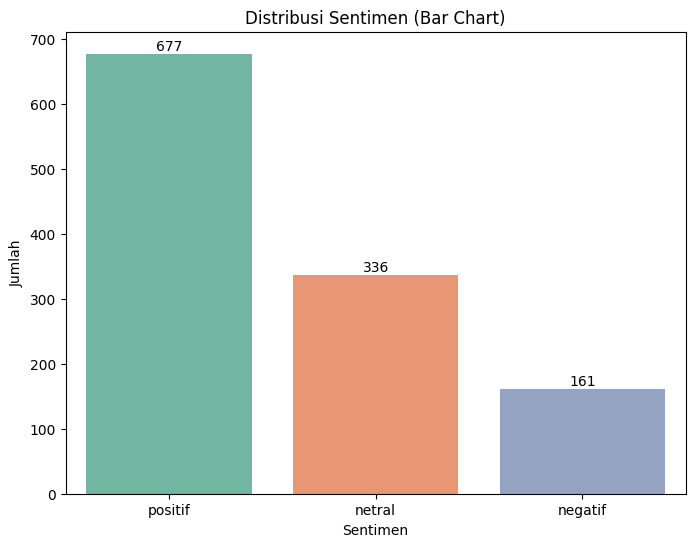

In [30]:
# Menghitung distribusi sentimen
sentiment_counts = df['sentiment'].value_counts()

# Bar Chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Distribusi Sentimen (Bar Chart)')
# Menampilkan jumlah di atas setiap bar
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 1, str(value), ha='center', va='bottom')

plt.show()

Distribusi Sentimen Pie Chart

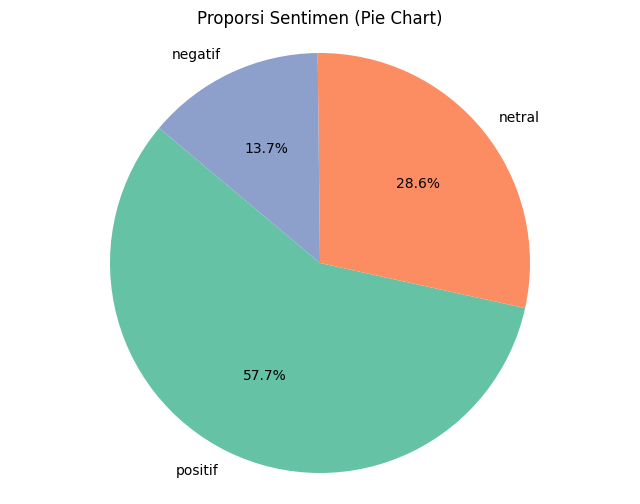

In [28]:
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140,
        colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.axis('equal')
plt.title('Proporsi Sentimen (Pie Chart)')
plt.show()

Wordcloud untuk ulasan Positif, Negatif dan Netral

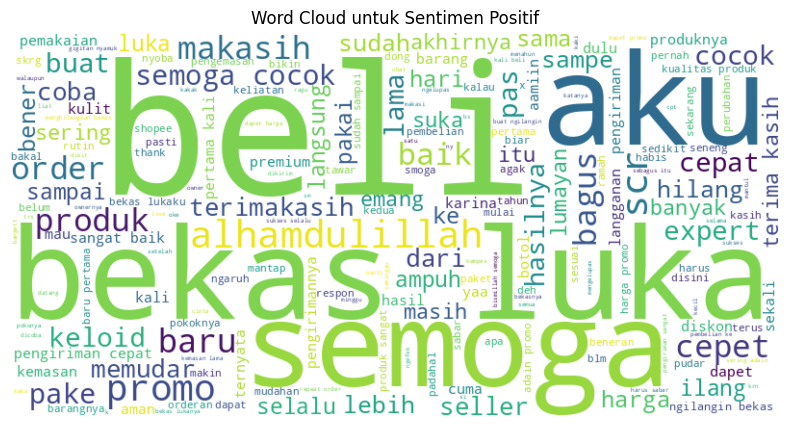

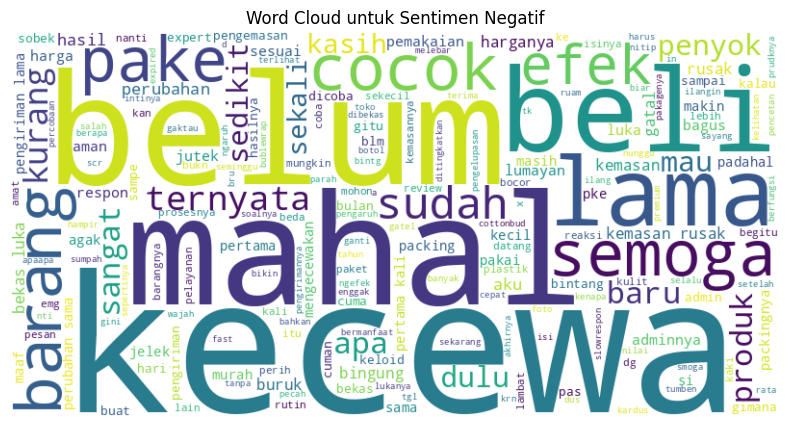

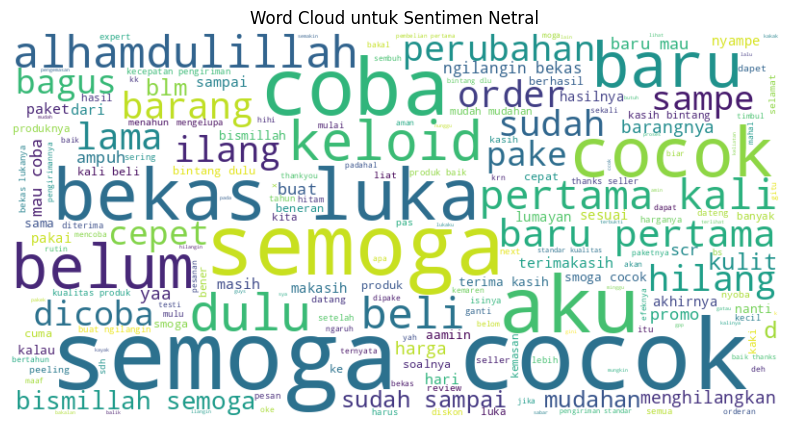

In [29]:
def generate_wordcloud(df, sentiment_label, title):
    # Verifikasi apakah ada data untuk sentimen yang diberikan
    if sentiment_label not in df['sentiment'].unique():
        print(f"Tidak ada data untuk sentimen: {sentiment_label}")
        return
    # Gabungkan teks untuk Word Cloud
    text = ' '.join(df[df['sentiment'] == sentiment_label]['cleaned_content'].fillna(''))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_tambahan).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Tampilkan Word Cloud untuk setiap sentimen
generate_wordcloud(df_selected, 'positif', 'Word Cloud untuk Sentimen Positif')
generate_wordcloud(df_selected, 'negatif', 'Word Cloud untuk Sentimen Negatif')
generate_wordcloud(df_selected, 'netral', 'Word Cloud untuk Sentimen Netral')